In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
from docutils.nodes import header
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
tagged_pitch_types = all_pitches['TaggedPitchType'].unique()
print(tagged_pitch_types)

auto_pitch_types = all_pitches['AutoPitchType'].unique()
print(auto_pitch_types)

['Fastball' 'Slider' 'ChangeUp' 'Curveball' 'Cutter' 'Other' 'Undefined'
 'Sinker' 'Knuckleball' 'Splitter' 'FourSeamFastBall' 'TwoSeamFastBall'
 'OneSeamFastBall']
['Sinker' 'Four-Seam' 'Curveball' 'Changeup' 'Slider' 'Cutter' nan
 'Splitter' 'Other']


In [4]:
fastballs = all_pitches[all_pitches['TaggedPitchType'].isin(['Fastball','Cutter','Sinker','FourSeamFastBall','TwoSeamFastBall','OneSeamFastBall'])]
off_speed = all_pitches[all_pitches['TaggedPitchType'].isin(['ChangeUp','Splitter'])]
breaking_balls = all_pitches[all_pitches['TaggedPitchType'].isin(['Slider','Curveball','Knuckleball'])]

print(fastballs.shape)
print(off_speed.shape)
print(breaking_balls.shape)

(152663, 167)
(31218, 167)
(80860, 167)


In [5]:
fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
breaking_balls['whiff'] = np.where(breaking_balls['PitchCall']=='StrikeSwinging',1,0)

C:\Users\ethan\AppData\Local\Temp\ipykernel_28852\2223113172.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fastballs['whiff'] = np.where(fastballs['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_28852\2223113172.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  off_speed['whiff'] = np.where(off_speed['PitchCall']=='StrikeSwinging',1,0)
C:\Users\ethan\AppData\Local\Temp\ipykernel_28852\2223113172.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [6]:
numeric_cols = fastballs.select_dtypes(include=['number']).columns
print(numeric_cols)

Index(['PitchNo', 'PAofInning', 'PitchofPA', 'PitcherId', 'BatterId', 'Inning',
       'Outs', 'Balls', 'Strikes', 'OutsOnPlay',
       ...
       'ThrowTrajectoryXc0', 'ThrowTrajectoryXc1', 'ThrowTrajectoryXc2',
       'ThrowTrajectoryYc0', 'ThrowTrajectoryYc1', 'ThrowTrajectoryYc2',
       'ThrowTrajectoryZc0', 'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2',
       'whiff'],
      dtype='object', length=121)


In [8]:
fb_preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [9]:

fastballs_X = fastballs[fb_preds]
fastballs_y = fastballs['whiff']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(fastballs_X, fastballs_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.67%


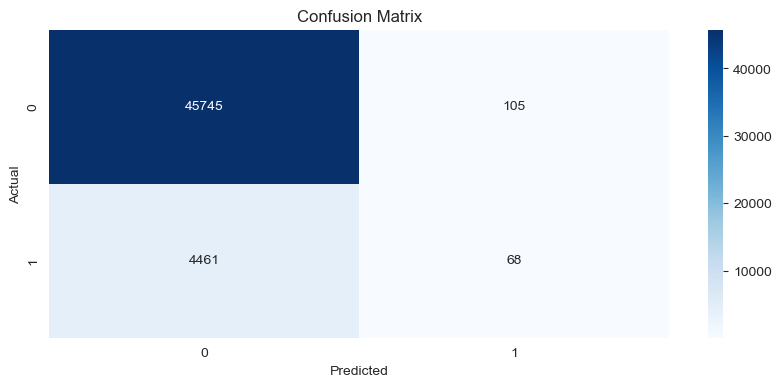

In [11]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [12]:
precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Precision: 0.6521
Recall: 0.5064
F1 Score: 0.4907


ROC AUC: 0.5064


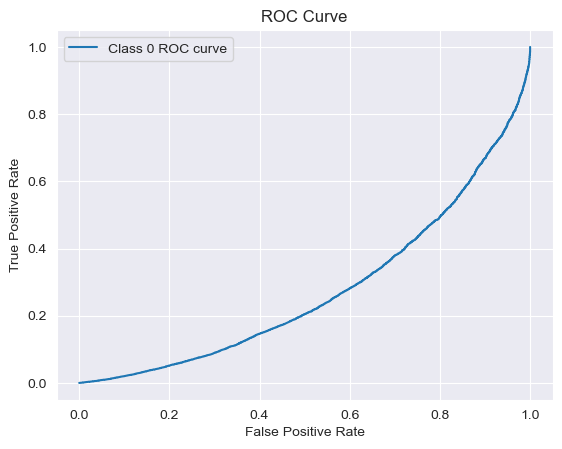

In [13]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 0, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

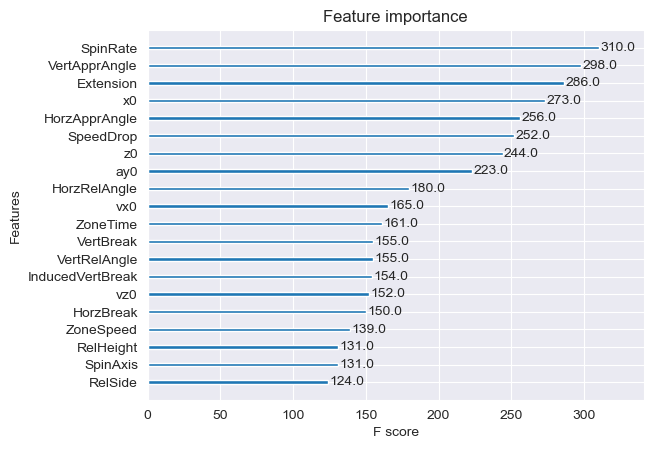

In [14]:
xgboost.plot_importance(model, max_num_features=20)

100%|===================| 101995/102284 [05:21<00:00]       

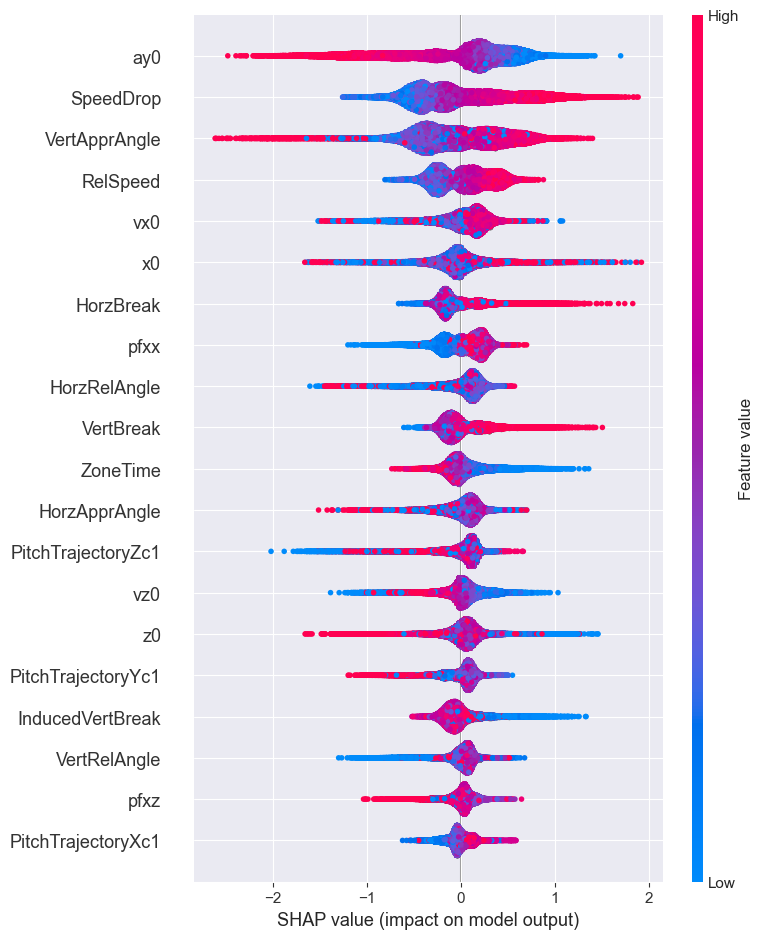

In [15]:
# Step 1: Initialize the SHAP explainer
explainer = shap.Explainer(model, X_train)

# Step 2: Calculate SHAP values for the training data
shap_values = explainer(X_train)

# Step 3: Plot a summary plot
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

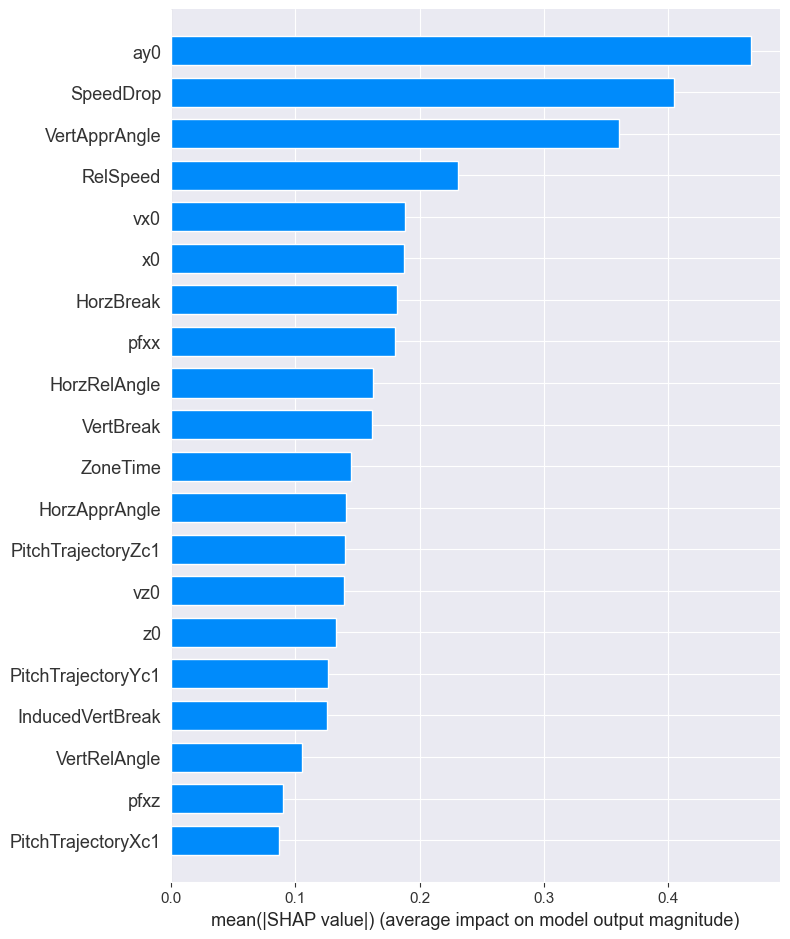

In [16]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type='bar')

In [17]:
all_preds = model.predict_proba(fastballs_X)[:,1]
mean_pred = np.mean(all_preds)

print(mean_pred)

sample = fastballs_X.sample(n=10)

sample_preds = model.predict_proba(sample)[:,1]

stuff = sample_preds/mean_pred

print(stuff*100)

0.09028009
[ 51.27891   82.76125   59.74811   45.211456 112.28975   66.018555
 218.29181  138.57478  259.44238  184.17987 ]


In [18]:
# Get unique values
unique_values = fastballs['Pitcher'].unique()

#Print list of pitchers to choose from
print(unique_values, len(unique_values))

# Create a dictionary to store subsets
subsets = {value: fastballs[fastballs['Pitcher'] == value] for value in unique_values}

['Dettmer, Nathan' 'Tidwell, Blade' 'Menefee, Joseph' ...
 'Pingeton, Anthony' 'Causey, A.J.' "O'Brien Cameron"] 2118


In [28]:
all_preds = model.predict_proba(fastballs_X)[:,1]
mean_pred = np.mean(all_preds)


p_skenes = subsets['Skenes, Paul']
p_skenes_X = p_skenes[fb_preds]

whiff_preds = model.predict_proba(p_skenes_X)[:,1]

stuff = whiff_preds/mean_pred

print(f"Paul Skenes Fastball stuff+:{np.mean(stuff*100)}")

Paul Skenes Fastball stuff+:180.56585693359375


In [21]:
print(p_skenes['TaggedPitchType'].unique())

['Fastball' 'Sinker']


In [22]:
ps_spd_avg = np.mean(p_skenes['RelSpeed'])
ps_spd_std = np.std(p_skenes['RelSpeed'])

ps_hgt_avg = np.mean(p_skenes['RelHeight'])
ps_hgt_std = np.std(p_skenes['RelHeight'])

ps_side_avg = np.mean(p_skenes['RelSide'])
ps_side_std = np.std(p_skenes['RelSide'])

In [23]:
similar_fastballs = fastballs[(fastballs['RelSpeed'] >= ps_spd_avg - ps_spd_std) &
                              (fastballs['RelSpeed'] <= ps_spd_avg + ps_spd_std) &
                              (fastballs['RelHeight'] >= ps_hgt_avg - ps_hgt_std) &
                              (fastballs['RelHeight'] <= ps_hgt_avg + ps_hgt_std) &
                              (fastballs['RelSide'] >= ps_side_avg - ps_side_std) &
                              (fastballs['RelSide'] <= ps_side_avg + ps_side_std)]

print(similar_fastballs.shape)

(304, 168)


this should include both his fastballs and sinkers

In [24]:
similar_fastballs['stuff_plus'] = (model.predict_proba(similar_fastballs[fb_preds])[:,1])/(mean_pred) * 100
print(similar_fastballs['stuff_plus'].head(10))


2656     15.058986
2660    106.821907
2661     81.725037
2662    154.114258
2663     57.286507
2667    119.592705
2669     15.310447
2670    187.644333
2695    225.799850
2698    127.307198
Name: stuff_plus, dtype: float32


C:\Users\ethan\AppData\Local\Temp\ipykernel_28852\1928036571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_fastballs['stuff_plus'] = (model.predict_proba(similar_fastballs[fb_preds])[:,1])/(mean_pred) * 100


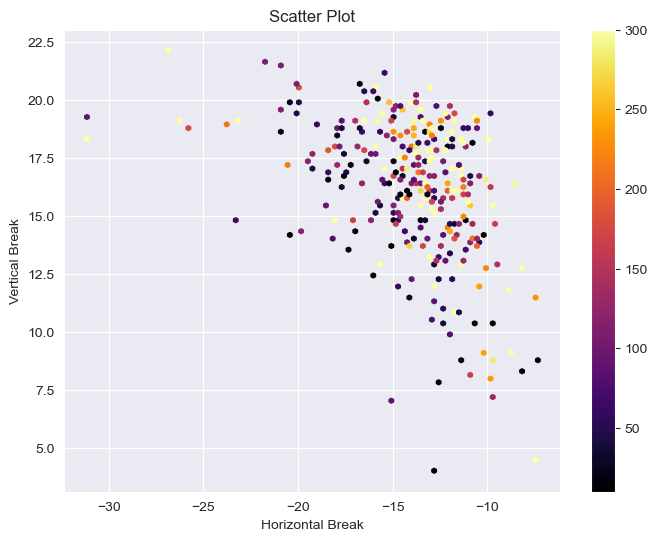

In [25]:
# Create scatter plot
plt.figure(figsize=(8, 6))
hb = plt.hexbin(x=similar_fastballs['VertBreak'], y=similar_fastballs['HorzBreak'], 
                C=similar_fastballs['stuff_plus'], cmap='inferno', reduce_C_function=np.mean,
                vmin=10, vmax=300)

plt.colorbar(hb, label='')

# Add labels and title
plt.xlabel('Horizontal Break')
plt.ylabel("Vertical Break")
plt.title("Scatter Plot")

# Show plot
plt.show()